<a href="https://colab.research.google.com/github/muhammadbabarkamal/Instance_segmentation/blob/main/CPM17instanceSegmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


IMports

In [2]:
import os
import sys
import json
import datetime
import numpy as np
from imgaug import augmenters as iaa
import matplotlib.pyplot as plt
from os import listdir
import scipy.io as sio
from skimage import data, io, util
from PIL import Image
from torchvision import transforms as T
import numpy as np
import requests
from io import BytesIO
import random
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import numpy as np
import torch.utils.data
import cv2
import torchvision.models.segmentation
import torch
import os

#Analysing and Loading Dataset

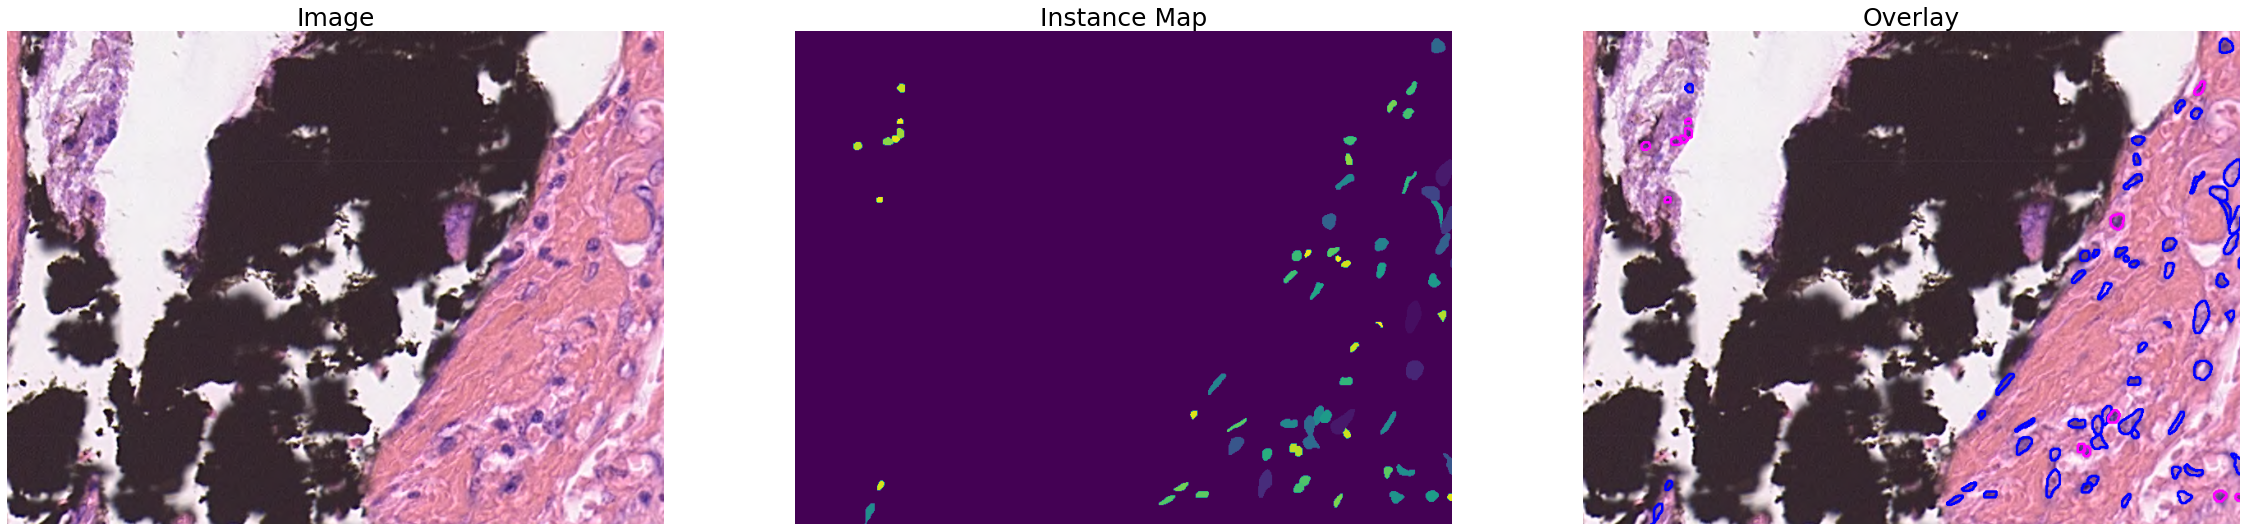

In [3]:
image= io.imread("/content/drive/MyDrive/Colab Notebooks/ACV Project/CoNSeP/Train/Images/train_2.png")
result_mat = sio.loadmat('/content/drive/MyDrive/Colab Notebooks/ACV Project/CoNSeP/Train/Labels/train_2.mat')
inst_map = result_mat['inst_map']
overlay= io.imread("/content/drive/MyDrive/Colab Notebooks/ACV Project/CoNSeP/Train/Overlay/train_2.png")
plt.figure(figsize=(40,20))

plt.subplot(1,3,1)
plt.imshow(image[:600,:800,:])
plt.axis('off')
plt.title('Image', fontsize=25)

plt.subplot(1,3,2)
plt.imshow(inst_map[:600,:800])
plt.axis('off')
plt.title('Instance Map', fontsize=25)

plt.subplot(1,3,3)
plt.imshow(overlay[:600,:800,:])
plt.axis('off')
plt
plt.title('Overlay', fontsize=25)

plt.show()

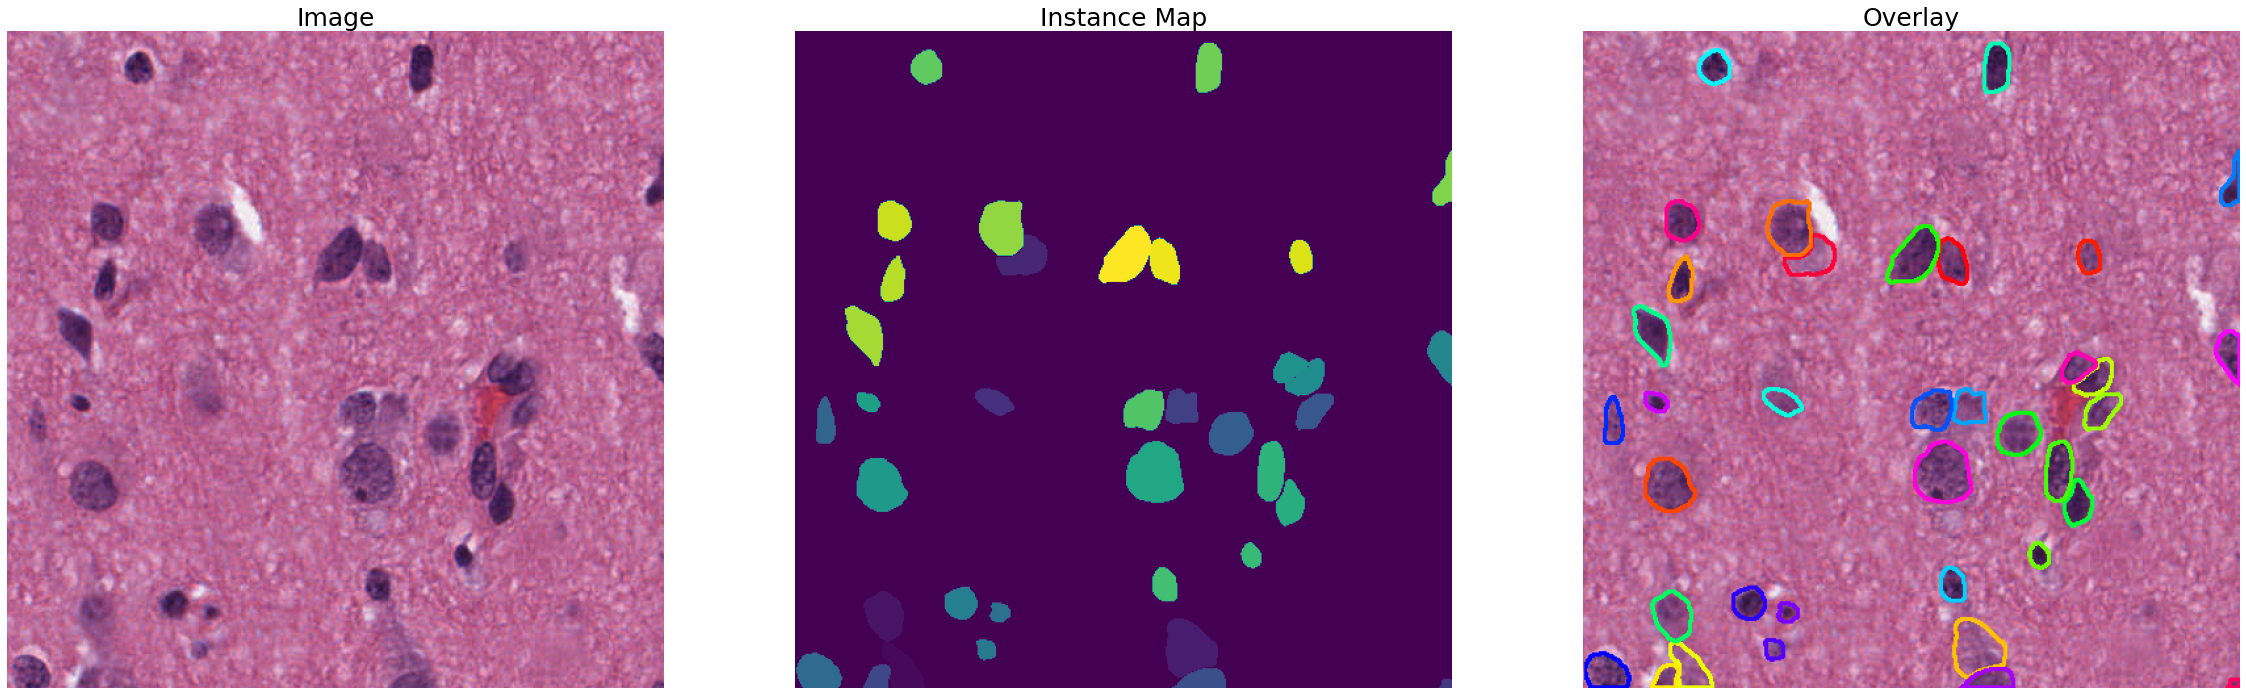

In [4]:
image= io.imread("/content/drive/MyDrive/Colab Notebooks/ACV Project/cpm17/cpm17/train/Images/image_05.png")
result = sio.loadmat('/content/drive/MyDrive/Colab Notebooks/ACV Project/cpm17/cpm17/train/Labels/image_05.mat')
inst = result['inst_map']
overlay= io.imread("/content/drive/MyDrive/Colab Notebooks/ACV Project/cpm17/cpm17/train/Overlay/image_05.png")
plt.figure(figsize=(40,20))
plt.subplot(1,3,1)
plt.imshow(image)
plt.axis('off')
plt.title('Image', fontsize=25)
plt.subplot(1,3,2)
plt.imshow(inst)
plt.axis('off')
plt.title('Instance Map', fontsize=25)
plt.subplot(1,3,3)
plt.imshow(overlay)
plt.axis('off')
plt.title('Overlay', fontsize=25)
plt.show()

Batch Size and image size

In [5]:
batchSize=16
imageSize=[300,300]
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')   # train on the GPU or on the CPU, if a GPU is not available
trainDir="/content/drive/MyDrive/Colab Notebooks/ACV Project/cpm17/cpm17/train/Images"

In [6]:
imgs=[]
for pth in os.listdir(trainDir):
    imgs .append(trainDir+"/"+pth)

In [8]:
trainDir_labels="/content/drive/MyDrive/Colab Notebooks/ACV Project/cpm17/cpm17/train/Labels"

#LoadData function

In [9]:
def loadData():
    batch_Imgs=[]
    batch_Data=[]# load images and masks
    for i in range(batchSize):
        idx=random.randint(0,len(imgs)-1)
        img = cv2.imread("/content/drive/MyDrive/Colab Notebooks/ACV Project/cpm17/cpm17/train/Images/"+ imgs[idx][76:-4]+".png")
        #print("/content/drive/MyDrive/Colab Notebooks/ACV Project/cpm17/cpm17/train/Images/"+ imgs[idx][76:-4]+".png")
        img = cv2.resize(img, (600,600), cv2.INTER_AREA)
        maskDir=os.path.join("/content/drive/MyDrive/Colab Notebooks/ACV Project/cpm17/cpm17/train/Labels/"+ imgs[idx][76:-4]+".mat")
        masks=[]
        #for mskName in list(maskDir):
        mat = sio.loadmat(maskDir)
        arr=mat['inst_map']
        arr=arr.astype(np.uint8)
        arr=cv2.resize(arr, (300,300), cv2.INTER_AREA)
        masks.append(arr)# get bounding box coordinates for each mask
        num_objs = len(masks)
        if num_objs==0: return loadData() # if image have no objects just load another image
        boxes = torch.zeros([num_objs,4], dtype=torch.float32)
        for i in range(num_objs):
            x,y,w,h = cv2.boundingRect(masks[i])
            boxes[i] = torch.tensor([x, y, x+w, y+h])
        masks = torch.as_tensor(masks, dtype=torch.uint8)
        img = torch.as_tensor(img, dtype=torch.float32)
        data = {}
        data["boxes"] =  boxes
        data["labels"] =  torch.ones((num_objs,), dtype=torch.int64)   # there is only one class
        data["masks"] = masks
        batch_Imgs.append(img)
        batch_Data.append(data)  # load images and masks
    batch_Imgs = torch.stack([torch.as_tensor(d) for d in batch_Imgs], 0)
    batch_Imgs = batch_Imgs.swapaxes(1, 3).swapaxes(2, 3)
    return batch_Imgs, batch_Data


#mask RCNN Implementation

In [10]:
model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)  # maskrcnn_resnet50_fpn load an instance segmentation model pre-trained pre-trained on COCO


Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth


  0%|          | 0.00/170M [00:00<?, ?B/s]

In [11]:
in_features = model.roi_heads.box_predictor.cls_score.in_features  # get number of input features for the classifier
model.roi_heads.box_predictor = FastRCNNPredictor(in_features,num_classes=2)  # replace the pre-trained head with a new one
model.to(device)# move model to the right devic

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

In [12]:
optimizer = torch.optim.Adagrad(model.parameters(), lr=0.001, initial_accumulator_value=0, eps=1e-10)
model.train()


MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

In [19]:
def multi_acc(y_pred, y_test):
    y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)    
    
    correct_pred = (y_pred_tags == y_test).float()
    acc = correct_pred.sum() / len(correct_pred)
    
    acc = torch.round(acc * 100)
    
    return acc

In [20]:
accuracy_stats = {
    'train': [],
    "val": []
}
loss_stats = {
    'train': [],
    "val": []
}

#Loss Function
loss_fn = torch.nn.CrossEntropyLoss()

In [21]:

def jaccard_distance_loss(y_true, y_pred, smooth=100):
    """
    Jaccard = (|X & Y|)/ (|X|+ |Y| - |X & Y|)
            = sum(|A*B|)/(sum(|A|)+sum(|B|)-sum(|A*B|))
    
    The jaccard distance loss is usefull for unbalanced datasets. This has been
    shifted so it converges on 0 and is smoothed to avoid exploding or disapearing
    gradient.
    
    Ref: https://en.wikipedia.org/wiki/Jaccard_index
    
    @url: https://gist.github.com/wassname/17cbfe0b68148d129a3ddaa227696496
    @author: wassname
    """
    intersection= (y_true * y_pred).abs().sum(dim=-1)
    sum_ = torch.sum(y_true.abs() + y_pred.abs(), dim=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return (1 - jac) * smooth

In [ ]:
from tqdm.notebook import tqdm
EPOCHS = 25
BATCH_SIZE = 100
LEARNING_RATE = 0.001
NUM_CLASSES = 10
print("Begin training.")
for e in tqdm(range(1, EPOCHS+1)):
    if EPOCHS >60:
          optimizer = torch.optim.Adam(model.parameters(), lr=0.0001);
    if EPOCHS >90:
      optimizer = torch.optim.Adam(model.parameters(), lr=0.00001);
    # TRAINING
    train_epoch_loss = 0
    train_epoch_acc = 0
    model.train()
    #for X_train_batch, y_train_batch in loadData():
    X_train_batch, y_train_batch = loadData()
    #X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
    optimizer.zero_grad()
        
    y_train_pred = model(X_train_batch)
    JLoss=jaccard_distance_loss(y_train_batch, y_train_pred)
    train_loss = loss_fn(y_train_pred, y_train_batch)
    train_acc = multi_acc(y_train_pred, y_train_batch)
        
    JLoss.backward()
        #train_loss.backward()
    optimizer.step()
        
    train_epoch_loss += JLoss.item()#train_loss.item()
    train_epoch_acc += train_acc.item()      
    print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(loadData()):.5f} | Val Loss: {train_epoch_loss/len(loadData()):.5f} | Train Acc: {train_epoch_acc/len(loadData()):.3f}| Val Acc: {train_epoch_acc/len(loadData()):.3f}')

In [14]:
for i in range(15):
            images, targets = loadData()
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            optimizer.zero_grad()
            loss_dict = model(images, targets)

            #train_acc = multi_acc(loss_dict.values(), targets)

            losses = sum(loss for loss in loss_dict.values())
            losses.backward()
            optimizer.step()
            print(i,'loss:', losses.item())
            if i%1==0:
                torch.save(model.state_dict(), str(i)+".torch")

0 loss: 1675.4400634765625
1 loss: -172537.59375
2 loss: -3351482880.0
3 loss: -443379473186816.0
4 loss: -2.734479920720773e+19
5 loss: -3.415985001104134e+23
6 loss: -4.5181649891413526e+23
7 loss: -4.1754288077074714e+23
8 loss: -4.559322125127996e+23
9 loss: -3.5048900209160994e+23
10 loss: -4.1292514191442056e+23
11 loss: -4.999019365387283e+23
12 loss: -4.5920823896813994e+23
13 loss: -3.624264234079033e+23
14 loss: -3.868589918183435e+23


#model Eval

In [13]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')   # train on the GPU or on the CPU, if a GPU is not available
model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)  # load an instance segmentation model pre-trained pre-trained on COCO
in_features = model.roi_heads.box_predictor.cls_score.in_features  # get number of input features for the classifier
model.roi_heads.box_predictor = FastRCNNPredictor(in_features,num_classes=2)  # replace the pre-trained head with a new one

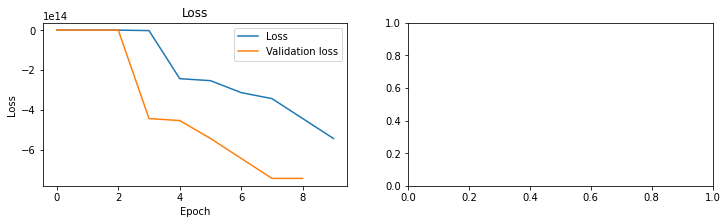

In [21]:
f, ax = plt.subplots(1,2, figsize=(12,3))
ax[0].plot(Loss, label="Loss")
ax[0].plot(LossB, label="Validation loss")
ax[0].set_title('Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()

In [52]:
model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
model.eval()
model.cuda()

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

In [15]:
N_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'nuclei']
# I will link the notebook in the description
# You can copy the class names from the description
# or the notebook
len(N_INSTANCE_CATEGORY_NAMES) # 91 classes including background

2

##get Prediction

In [54]:
def get_prediction(img_path, threshold=0.1, url=False):
  if url: # We have to request the image
    response = requests.get(img_path)
    img = Image.open(BytesIO(response.content))
  else:
    img = Image.open(img_path).convert('RGB') # This is for local images      test_image = Image.open(test_image_name).convert('RGB')
  transform = T.Compose([T.ToTensor()]) # Turn the image into a torch.tensor
  img = transform(img)
  img = img.cuda() # Only if GPU, otherwise comment this line
  pred = model([img]) # Send the image to the model. This runs on CPU, so its going to take time
  #Let's change it to GPU
  # pred = pred.cpu() # We will just send predictions back to CPU
  # Now we need to extract the bounding boxes and masks
  pred_score = list(pred[0]['scores'].detach().cpu().numpy())
  print(pred_score)
  pred_t = [pred_score.index(x) for x in pred_score if x > threshold][-1]
  masks = (pred[0]['masks'] > 0.5).squeeze().detach().cpu().numpy()
  pred_class = [N_INSTANCE_CATEGORY_NAMES[i] for i in list(pred[0]['labels'].cpu().numpy())]
  pred_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(pred[0]['boxes'].detach().cpu().numpy())]
  masks = masks[:pred_t+1]
  pred_boxes = pred_boxes[:pred_t+1]
  pred_class = pred_class[:pred_t+1]
  return masks, pred_boxes, pred_class

In [16]:
def random_color_masks(image):
  # I will copy a list of colors here
  colors = [[0, 255, 0],[0, 0, 255],[255, 0, 0],[0, 255, 255],[255, 255, 0],[255, 0, 255],[80, 70, 180], [250, 80, 190],[245, 145, 50],[70, 150, 250],[50, 190, 190]]
  r = np.zeros_like(image).astype(np.uint8)
  g = np.zeros_like(image).astype(np.uint8)
  b = np.zeros_like(image).astype(np.uint8)
  r[image==1], g[image==1], b[image==1] = colors[random.randrange(0, 10)]
  colored_mask = np.stack([r,g,b], axis=2)
  return colored_mask

In [17]:
def instance_segmentation(img_path, threshold=0.5, rect_th=3,
                          text_size=3, text_th=3, url=False):
  masks, boxes, pred_cls = get_prediction(img_path, threshold=threshold, url=url)
  if url:
     A=a # If we have a url image
  else: # Local image
    img = cv2.imread(img_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # For working with RGB images instead of BGR
  for i in range(len(masks)):
    rgb_mask = random_color_masks(masks[i])
    img = cv2.addWeighted(img, 1, rgb_mask, 0.5, 0)
    cv2.rectangle(img, boxes[i][0], boxes[i][1], color=(0, 255, 0), thickness=rect_th)
    cv2.putText(img, pred_cls[i], boxes[i][0], cv2.FONT_HERSHEY_SIMPLEX, text_size, (0, 255, 0), thickness=text_th)
  return img, pred_cls, masks[i]

In [26]:
a=cv2.imread('/content/image_00.png')

In [27]:
a.shape

(256, 256, 3)

In [ ]:
img, pred_classes, masks = instance_segmentation('./image_00.png')

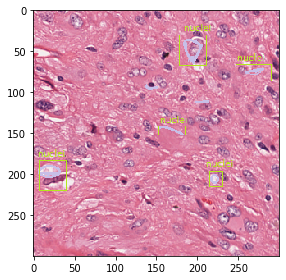

In [4]:
plt.imshow(img)

In [18]:
#model.load_state_dict(torch.load("/content/3.h5"))
#model.to(device)# move model to the right devic
model.eval()

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

In [38]:
images=cv2.imread('/content/drive/MyDrive/Colab Notebooks/hover/processed/consep/train/input/train_5.png')
images

array([[[244, 225, 241],
        [254, 237, 252],
        [255, 243, 255],
        ...,
        [199, 121, 154],
        [222, 144, 177],
        [239, 161, 194]],

       [[243, 222, 239],
        [253, 232, 250],
        [253, 231, 250],
        ...,
        [183, 104, 138],
        [206, 129, 162],
        [227, 150, 183]],

       [[244, 225, 243],
        [243, 222, 241],
        [235, 213, 233],
        ...,
        [181, 103, 138],
        [201, 124, 158],
        [219, 143, 177]],

       ...,

       [[255, 247, 255],
        [253, 243, 250],
        [255, 244, 251],
        ...,
        [204, 161, 193],
        [206, 171, 202],
        [214, 185, 215]],

       [[255, 250, 255],
        [255, 249, 255],
        [255, 246, 254],
        ...,
        [211, 168, 199],
        [206, 170, 200],
        [206, 174, 204]],

       [[255, 249, 255],
        [255, 252, 255],
        [255, 245, 253],
        ...,
        [220, 176, 206],
        [210, 170, 199],
        [203, 164, 194]]

In [39]:
images = cv2.resize(images, (600,600), cv2.INTER_LINEAR)
images = torch.as_tensor(images, dtype=torch.float32).unsqueeze(0)
images=images.swapaxes(1, 3).swapaxes(2, 3)
images = list(image.to(device) for image in images)
print(images)


[tensor([[[244., 245., 250.,  ..., 229., 237., 239.],
         [244., 245., 249.,  ..., 227., 235., 237.],
         [243., 245., 249.,  ..., 221., 229., 232.],
         ...,
         [255., 255., 255.,  ..., 206., 205., 205.],
         [255., 255., 255.,  ..., 207., 204., 203.],
         [255., 255., 255.,  ..., 207., 204., 203.]],

        [[225., 226., 232.,  ..., 151., 158., 161.],
         [224., 226., 231.,  ..., 149., 157., 159.],
         [223., 225., 229.,  ..., 144., 152., 155.],
         ...,
         [249., 250., 250.,  ..., 170., 170., 170.],
         [249., 249., 250.,  ..., 168., 166., 165.],
         [249., 249., 251.,  ..., 167., 165., 164.]],

        [[241., 243., 247.,  ..., 184., 191., 194.],
         [240., 242., 247.,  ..., 182., 190., 192.],
         [240., 241., 246.,  ..., 177., 185., 188.],
         ...,
         [255., 255., 255.,  ..., 199., 200., 200.],
         [255., 255., 255.,  ..., 197., 196., 195.],
         [255., 255., 255.,  ..., 197., 195., 194.]]

In [40]:
with torch.no_grad():
    pred = model(images)
    print(pred)


[{'boxes': tensor([[  0.0000,   0.0000, 209.7489, 600.0000],
        [  0.0000,   0.0000, 600.0000, 600.0000]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([1.0000, 0.9998], device='cuda:0'), 'masks': tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]], device='cuda:0')}]


In [42]:
pred[0]

{'boxes': tensor([[  0.0000,   0.0000, 600.0000, 600.0000],
         [552.8934,   0.0000, 552.9435, 600.0000],
         [301.4953,   0.0000, 506.3083, 600.0000],
         [559.9277,   0.0000, 566.5420, 600.0000],
         [564.7583,   0.0000, 564.8060, 600.0000],
         [593.5364,   0.0000, 593.5700, 600.0000],
         [599.9683,   0.0000, 600.0000, 599.4015]]),
 'labels': tensor([1, 1, 1, 1, 1, 1, 1]),
 'masks': tensor([[[[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
            0.0000e+00, 0.0000e+00],
           [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
            0.0000e+00, 0.0000e+00],
           [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
            0.0000e+00, 0.0000e+00],
           ...,
           [2.0468e-09, 2.2367e-09, 2.4265e-09,  ..., 4.1355e-01,
            3.8355e-01, 3.5354e-01],
           [1.8983e-09, 2.0744e-09, 2.2504e-09,  ..., 3.8355e-01,
            3.5572e-01, 3.2789e-01],
           [1.7498e-09, 1.9121e-09, 2.0744e-09,  .

In [ ]:
im= images[0].swapaxes(0, 2).swapaxes(0, 1).detach().cpu().numpy().astype(np.uint8)
im2 = im.copy()
#scr=[]
for i in range(len(pred[0]['masks'])):
    msk=pred[0]['masks'][i,0].detach().cpu().numpy()
    scr=pred[0]['scores'][i].detach().cpu().numpy()
    print(scr)
    if scr>0.8 :
        im2[:,:,0][msk>0.5] = random.randint(0,255)
        im2[:, :, 1][msk > 0.5] = random.randint(0,255)
        im2[:, :, 2][msk > 0.5] = random.randint(0, 255)
cv2.imshow(str(scr), np.hstack([im,im2]))
cv2.waitKey()

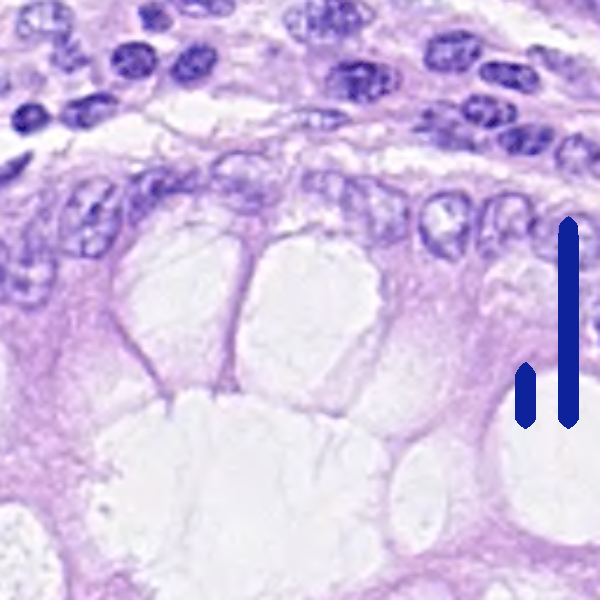

In [42]:
from google.colab.patches import cv2_imshow
cv2_imshow( im2)
#cv2.waitKey()